#**Set up files and notebook**

In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from mpl_toolkits.basemap import Basemap

In [4]:
# Authenticate google drive access and mount it to /content/drive path.
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Check the contents of the Data/ directory.
import glob
DATA_PATH_PREFIX = '/content/drive/My Drive/Colab Notebooks/Flood_game'
def get_data_file(file_name):
  return DATA_PATH_PREFIX+'/'+file_name 
glob.glob(DATA_PATH_PREFIX + '/*')

['/content/drive/My Drive/Colab Notebooks/Flood_game/Data',
 '/content/drive/My Drive/Colab Notebooks/Flood_game/DTF: Event analytics.gdoc',
 '/content/drive/My Drive/Colab Notebooks/Flood_game/DTF Level analysis [010620 - 200720].gslides',
 '/content/drive/My Drive/Colab Notebooks/Flood_game/DTF_event_analytics_June_July2020.ipynb',
 '/content/drive/My Drive/Colab Notebooks/Flood_game/DTF Level analysis [190820 - 290820].gslides',
 '/content/drive/My Drive/Colab Notebooks/Flood_game/DTF_event_analytics_August2020.ipynb']

In [4]:
prefix = '/content/drive/My Drive/Colab Notebooks/Flood_game/Data'
def get_file(file_name):
  return prefix + '/' + file_name
glob.glob(prefix + '/*')

['/content/drive/My Drive/Colab Notebooks/Flood_game/Data/events_200829.json',
 '/content/drive/My Drive/Colab Notebooks/Flood_game/Data/events_200720.json']

#**Definitions**

##**Helpers**

In [ ]:
def create_df_country(data, countries):
  data = data[data.country.isin(countries)]
  return data

def date_datetime(column):
  column = pd.to_datetime(column, unit='us')       #.dt.time
  return column

def calculate_percentage(data, column):
  data['transition_perc'] = round((data[column] / data[column][0])*100, 1)
  return data

def round_time(time):
  return time.round(freq='S')

def extract_dict(data, column):
  data_extracted = data[column].apply(pd.Series)
  return data_extracted

##**Functions' library**

In [ ]:
def find_all_levels(event_params_list):
  id = []
  for i in range(len(event_params_list)):
    for key in event_params_list[i]:
      if 'level_id' == event_params_list[i]['key']:
        return event_params_list[i]['value']['int_value']
  return None

def event_level_aggr(group):
  result = {}
  result['avg_play_time'] = avg_play_time(group) 
  return pd.Series(result, index=result.keys())

def check_length_event(data, index):
  length = []
  for key, group in data:
    length.append(group.shape[0])
  max(length)
  return length.index(index)

def give_sum_session(group):
  result = {}
  result['number_of_sessions'] = len(group)
  return pd.Series(result, index=result.keys())


def find_min_max(group):
  result = {}
  result['min_time'] = min(group.session_length)
  result['max_time'] = max(group.session_length)
  return pd.Series(result, index=result.keys())

def find_start_end(group):
  result = {}
  result['start_session_time'] = group.event_timestamp.iloc[0]
  result['end_session_time'] = group.event_timestamp.iloc[-1]
  return pd.Series(result, index=result.keys())

def calculate_break(data):
  data['break_between_sessions'] = data.start_session_time - data.end_session_time.shift(1)
  return data

def calculate_longer_gaps(data):
  longer_gaps = data[data.break_between_sessions > datetime.timedelta(hours=1)]
  users_more_sessions = data.user_pseudo_id.count()
  users_longer_gaps = longer_gaps.user_pseudo_id.count()
  percent = round((users_longer_gaps / users_more_sessions)*100, 1)
  return percent

def calculate_progress_amount(data):
  for i in range(1, data.shape[0]):
    data.amount_players.iloc[i] = sum(data.amount_players[i:])
  return data

def count_days(data):
  data['day_Nr'] = 1
  print(len(data.session_date))
  for i in range(len(data.session_date)-1):
    if data.user_pseudo_id.iloc[i+1] != data.user_pseudo_id.iloc[i]:
      data.day_Nr.iloc[i+1] = 1
    elif data.user_pseudo_id.iloc[i+1] == data.user_pseudo_id.iloc[i] and data.session_date.iloc[i+1] != data.session_date.iloc[i]:
      data.day_Nr.iloc[i+1] = data.day_Nr.iloc[i] + 1
    elif data.user_pseudo_id.iloc[i+1] == data.user_pseudo_id.iloc[i] and data.session_date.iloc[i+1] == data.session_date.iloc[i]:
      data.day_Nr.iloc[i+1] = data.day_Nr.iloc[i]
  return data

def count_difference_days(data):
  data['day_dif'] = 0
  for i in range(len(data.session_date)-1):
    if data.user_pseudo_id.iloc[i+1] == data.user_pseudo_id.iloc[i]:
      data.day_dif.iloc[i+1] = data.session_date.iloc[i+1] - data.session_date.iloc[i]
    elif data.user_pseudo_id.iloc[i+1] != data.user_pseudo_id.iloc[i]:
      data.day_dif.iloc[i+1] = 0
  return data

def combine_frames(data1, data2, original_column):
  final_data = pd.concat([data1, data2], axis=1).drop(original_column, axis=1)
  return final_data

def order_descending(data, series):
  data = data.sort_values(series, ascending=False)
  return data

def give_month(takeoff):
  s = takeoff[5:7]
  month_to_name = {'01': 1, '02':2, '03': 3, '04':4, 
                   '05':5, '06':6, '07':7, '08':8, '09':9,
                   '10':10, '11':11, '12':12}
  return month_to_name[s]
  
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December']

def get_month_index(month):
  return month-1

def get_country_index(country):
  return country_idx[country]

def clean_time(time):
  time = time[2:4] + ":" + time[5:7] + ":" + time[8:10]
  return time

def find_mistake_time(time):
  if time[6] == "-":
    return False
  else:
    return True

def define_time_categories(time):
  if time[0] != '0' and time[3] in ['0', '1', '2']:
    t = int(time[0:2]) + 0.5
  elif time[0] == '0' and time[3] in ['0', '1', '2']:
    t = int(time[1]) + 0.5
  elif time[0] == '0' and time[3] in ['3', '4', '5']:
    t = int(time[1]) + 0.9
  elif time[0] != '0' and time[3] in ['3', '4', '5']:
    t = int(time[0:2]) + 0.9
  return t

time_categories = ['0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00', '4:30', '5:00', '5:30', '6:00', 
                   '6:30', '7:00', '7:30', '8:00', '8:30', '9:00', '9:30', '10:00', '10:30', '11:00']

def make_delta_time(time):
  h, m, s = time.split(':')
  return datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s))

def return_to_time(number):
  number = pd.TimedeltaIndex(number, unit='m')
  return number

def myplot(graph):
  graph = graph[graph.index < pd.Timedelta(seconds=5*3600)]
  ax = graph.plot(figsize=(25,15)) 
  vals = ax.get_yticks()
  ax.set_yticklabels(['{}%'.format(x) for x in vals])

def get_percents(amount):
  amount = amount / sum(amount)*100
  return amount

#**Read and clean the original data**

##**Definitions**

In [ ]:
def read_data(file):
  data = pd.read_json(get_file(file), orient='records', lines=True)
  return data

def cleanup(data):
  data = data[['event_date', 'event_timestamp', 'event_name', 'event_params', 
               'user_pseudo_id', 'geo', 'app_info', 'traffic_source', 'platform', 
               'event_previous_timestamp']]
  return data

def date_datetime(column):
  column = pd.to_datetime(column, unit='us')       #.dt.time
  return column

def find_key_value_string(event_param_list, key):
  for event_param_dict in event_param_list:
    if key == event_param_dict['key']:
      return event_param_dict['value']['string_value']
  return None

def find_key_value(event_param_list, key):
  for event_param_dict in event_param_list:
    if key == event_param_dict['key']:
      return int(event_param_dict['value']['int_value'])
  return None

def find_key_value_int_as_str(event_param_list, key):
  for event_param_dict in event_param_list:
    if key == event_param_dict['key']:
      return str(event_param_dict['value']['int_value'])
  return None

def find_key_value_int_as_str(event_param_list, key):
  for event_param_dict in event_param_list:
    if key == event_param_dict['key']:
      return str(event_param_dict['value']['int_value'])
  return None

def find_country(geo_dict):
  if 'country' in geo_dict:
    return geo_dict['country']
  return None

def find_version(app_dict):
  if 'version' in app_dict:
    return app_dict['version']
  return None

def concate_dict_to_string(traf_dict):
  source = ''
  for key, value in traf_dict.items():
    source += key[0] + ':' + value + ','
  return source

def give_levels(group):
  result = {}
  result['level_1'] = group.level_id.isin([1]).sum()
  result['level_2'] = group.level_id.isin([2]).sum()
  result['level_3'] = group.level_id.isin([3]).sum()
  result['level_4'] = group.level_id.isin([4]).sum()
  result['level_5'] = group.level_id.isin([5]).sum()
  result['level_8'] = group.level_id.isin([8]).sum()
  result['level_9'] = group.level_id.isin([9]).sum()
  return pd.Series(result, index=result.keys())

def calc_players_countries(group):
  result = {}
  result['sum_players'] = len(group.user_pseudo_id)
  return pd.Series(result, index=result.keys())

##**Read the data**

In [ ]:
original_data = read_data('events_200829.json')
print(original_data.shape)
original_data.head()

(24472, 17)


,event_date,event_timestamp,event_name,event_params,event_bundle_sequence_id,event_server_timestamp_offset,user_pseudo_id,user_properties,user_first_touch_timestamp,device,geo,app_info,traffic_source,stream_id,platform,items,event_previous_timestamp
0,20200828,1598616792034000,app_remove,"[{'key': 'firebase_event_origin', 'value': {'s...",13,-882025,ab7f8ab8eb72cfd503a08429fb5e6b17,"[{'key': 'ga_session_number', 'value': {'int_v...",1598359233359000,"{'category': 'mobile', 'mobile_brand_name': 'H...","{'continent': 'Europe', 'country': 'United Kin...","{'id': 'com.TaterGames.DamTheFlood', 'version'...","{'name': '(direct)', 'medium': '(none)', 'sour...",1918950609,ANDROID,[],NaN
1,20200828,1598610325684000,app_remove,"[{'key': 'firebase_event_origin', 'value': {'s...",9,2627094,a42917df7f7c1710f6e91b097f4d21a7,"[{'key': 'ga_session_number', 'value': {'int_v...",1598118372271000,"{'category': 'tablet', 'mobile_brand_name': 'S...","{'continent': 'Europe', 'country': 'United Kin...","{'id': 'com.TaterGames.DamTheFlood', 'version'...","{'name': '(direct)', 'medium': '(none)', 'sour...",1918950609,ANDROID,[],NaN
2,20200828,1598634307770000,app_remove,"[{'key': 'firebase_event_origin', 'value': {'s...",5,-1114701,8fca30b80866a6e4a97769a04cdba038,"[{'key': 'ga_session_number', 'value': {'int_v...",1598546134112000,"{'category': 'mobile', 'mobile_brand_name': 'H...","{'continent': 'Europe', 'country': 'United Kin...","{'id': 'com.TaterGames.DamTheFlood', 'version'...","{'name': '(direct)', 'medium': '(none)', 'sour...",1918950609,ANDROID,[],NaN
3,20200828,1598642358014000,session_start,"[{'key': 'firebase_event_origin', 'value': {'s...",5,-4714004,1df8a053cb8e5c4f515abcd3dfc14de2,"[{'key': 'ga_session_number', 'value': {'int_v...",1598256870014000,"{'category': 'mobile', 'mobile_brand_name': 'H...","{'continent': 'Europe', 'country': 'United Kin...","{'id': 'com.TaterGames.DamTheFlood', 'version'...","{'name': '(direct)', 'medium': '(none)', 'sour...",1918950609,ANDROID,[],1.598257e+15
4,20200828,1598642358045001,screen_view,"[{'key': 'entrances', 'value': {'int_value': '...",5,-4714004,1df8a053cb8e5c4f515abcd3dfc14de2,"[{'key': 'ga_session_number', 'value': {'int_v...",1598256870014000,"{'category': 'mobile', 'mobile_brand_name': 'H...","{'continent': 'Europe', 'country': 'United Kin...","{'id': 'com.TaterGames.DamTheFlood', 'version'...","{'name': '(direct)', 'medium': '(none)', 'sour...",1918950609,ANDROID,[],1.598257e+15


##**Clean up the data**

**Delete unimportant columns** 

In [ ]:
original_data_cleaned = cleanup(original_data)
original_data_cleaned.event_timestamp = date_datetime(original_data_cleaned.event_timestamp)
original_data_cleaned = original_data_cleaned.sort_values('event_timestamp')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


**Take interesting keys from dictionaries to new columns**

In [ ]:
original_data_cleaned['ga_session_id'] = original_data_cleaned['event_params'].apply(lambda x: find_key_value_int_as_str(x, 'ga_session_id'))
original_data_cleaned['level_id'] = original_data_cleaned['event_params'].apply(lambda x: find_key_value(x, 'level_id'))
original_data_cleaned['medium'] = original_data_cleaned['event_params'].apply(lambda x: find_key_value_string(x, 'medium'))
original_data_cleaned['country'] = original_data_cleaned['geo'].apply(find_country)
original_data_cleaned['app_version'] = original_data_cleaned['app_info'].apply(find_version)
original_data_cleaned['traff_source'] = original_data_cleaned['traffic_source'].apply(concate_dict_to_string)

**Delete original columns with dictionaries**

In [ ]:
data_fin = original_data_cleaned.drop(['event_params', 'geo', 'app_info', 'traffic_source'], axis=1)
data_fin.head()

,event_date,event_timestamp,event_name,user_pseudo_id,platform,event_previous_timestamp,ga_session_id,level_id,medium,country,app_version,traff_source
697,20200819,2020-08-19 01:14:03.397000,app_remove,a6f4f9941e8870b98270533f21eb0b87,ANDROID,NaN,1595135175,NaN,None,Australia,0.4.18,"n:(direct),m:(none),s:(direct),"
698,20200819,2020-08-19 05:11:17.996000,app_remove,b596c061438b59c29cec3f00c68b3fe9,ANDROID,NaN,1594355023,NaN,None,Australia,0.4.36,"n:(direct),m:(none),s:(direct),"
737,20200819,2020-08-19 06:56:28.143001,screen_view,6E42167FF75B4778A171484510699290,IOS,1.597680e+15,1597820189,NaN,None,Finland,0.4.41,"n:(direct),m:(none),s:(direct),"
738,20200819,2020-08-19 06:56:29.797000,login,6E42167FF75B4778A171484510699290,IOS,1.597680e+15,1597820189,NaN,None,Finland,0.4.41,"n:(direct),m:(none),s:(direct),"
736,20200819,2020-08-19 06:56:29.912000,session_start,6E42167FF75B4778A171484510699290,IOS,1.597680e+15,1597820189,NaN,None,Finland,0.4.41,"n:(direct),m:(none),s:(direct),"


In [ ]:
data_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24472 entries, 697 to 1037
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   event_date                24472 non-null  int64         
 1   event_timestamp           24472 non-null  datetime64[ns]
 2   event_name                24472 non-null  object        
 3   user_pseudo_id            24472 non-null  object        
 4   platform                  24472 non-null  object        
 5   event_previous_timestamp  15692 non-null  float64       
 6   ga_session_id             23009 non-null  object        
 7   level_id                  12961 non-null  float64       
 8   medium                    509 non-null    object        
 9   country                   24472 non-null  object        
 10  app_version               24472 non-null  object        
 11  traff_source              24472 non-null  object        
dtypes: datetime64[ns]

##**Choosing the countries for analysis**

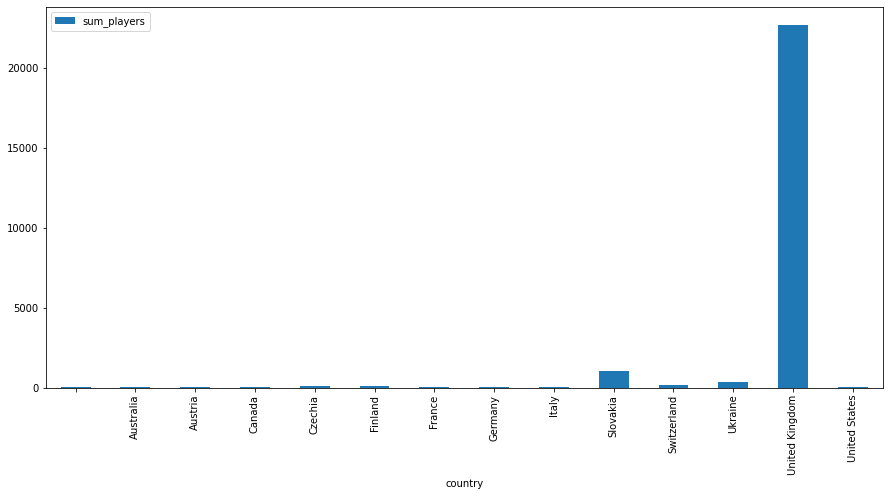

In [ ]:
data_countries = data_fin.groupby('country').apply(calc_players_countries).reset_index()
data_countries.plot.bar(x='country', y='sum_players', figsize=(15,7))

##**Specific cleaning, debugging for this campaign**

###**Sellecting users who did have level 9 but not level 8**

In [ ]:
players_levels = data_fin.groupby(['user_pseudo_id']).apply(give_levels).reset_index()
print(len(data_fin.user_pseudo_id.unique()), 'unique players')
players_level_8 = players_levels[players_levels.level_8 > 0]
players_level_9 = players_levels[players_levels.level_9 > 0]
print(len(players_level_8), 'unique players - level 8')
print(len(players_level_9), 'unique players - level 9')
players_level_8_9 = players_level_8.merge(players_level_9, how='outer')
players_level_8_9 = players_level_8_9[players_level_8_9.level_8 == 0]

953 unique players
65 unique players - level 8
178 unique players - level 9


Analazing why some users didn't have level 8 but had level 9 => reason: in this version was level 8 put after level 13.

In [ ]:
#user1 = data_fin[data_fin.user_pseudo_id == '041C7ABA00F5430B909B30F2F52EA8EC']
#user1[['user_pseudo_id', 'event_timestamp', 'event_name', 'level_id', 'country', 'app_version']]

###**Analysis of games dropping from level 4 to level 5**

**Unique players on levels**

In [ ]:
players_level_1 = players_levels[players_levels.level_1 > 0]
players_level_2 = players_levels[players_levels.level_2 > 0]
players_level_3 = players_levels[players_levels.level_3 > 0]
players_level_4 = players_levels[players_levels.level_4 > 0]
players_level_5 = players_levels[players_levels.level_5 > 0]
print('Unique players per level and calculated drop per level')
print(len(players_level_1), ' - level 1')
print(len(players_level_2), round(100 - len(players_level_2) / len(players_level_1)*100,2), '% drop', '- level 2')
print(len(players_level_3), round(100 - len(players_level_3) / len(players_level_2)*100,2), '% drop', ' - level 3')
print(len(players_level_4), round(100 - len(players_level_4) / len(players_level_3)*100,2), '% drop', ' - level 4')
print(len(players_level_5), round(100 - len(players_level_5) / len(players_level_4)*100,2), '% drop', ' - level 5')

Unique players per level and calculated drop per level
910  - level 1
844 7.25 % drop - level 2
703 16.71 % drop  - level 3
568 19.2 % drop  - level 4
326 42.61 % drop  - level 5


In [ ]:
players_level_4_5 = players_level_5.merge(players_level_4, how='outer')
players_level_4_5 = players_level_4_5[players_level_4_5.level_5 == 0].drop(['level_1', 'level_2', 'level_3', 'level_8', 'level_9'], axis=1)

**All users who stopped after level 4**

In [ ]:
players_stopped = players_level_4_5.user_pseudo_id
players_stopped_df = data_fin[data_fin.user_pseudo_id.isin(players_stopped)]
level_4_df =  players_stopped_df[players_stopped_df.level_id == 4]
level_4_finish = level_4_df[level_4_df.event_name == 'level_finish']
players_level_4_finish = level_4_finish.user_pseudo_id.unique()
level_4_finishes = level_4_finish.groupby(['user_pseudo_id']).size().reset_index().rename(columns={0: 'num_finishes'})
level_4__more_finishes = level_4_finishes[level_4_finishes.num_finishes > 1]


**All user who removed app after level 4**

In [ ]:
players_removed_app_df = players_stopped_df[players_stopped_df.event_name == 'app_remove']
players_removed_app = players_removed_app_df.user_pseudo_id
sum_players_removed_app = len(players_removed_app_df)

**All users who stopped after level 4 but didn't remove the app**

In [ ]:
players_stopped_NOT_removed_app = set(players_stopped) - set(players_removed_app)
players_stopped_NOT_removed_app_df = data_fin[data_fin.user_pseudo_id.isin(players_stopped_NOT_removed_app)]

In [ ]:
print(len(players_level_4_5), 'players stopped playing at level 4.')
print(len(players_level_4_finish), 'players finished the level 4 at least once.')
print(len(level_4__more_finishes), 'players finishes the level 4 more than once.')
print(sum_players_removed_app, 'players removed the app after level 4.')
print(len(players_stopped_NOT_removed_app), 'players stopped playing after level 4, but didn\'t remove the app.')

242 players stopped playing at level 4.
193 players finished the level 4 at least once.
48 players finishes the level 4 more than once.
111 players removed the app after level 4.
132 players stopped playing after level 4, but didn't remove the app.


###**Analysis of games dropping from level 3 to level 4**

**All users who stopped after level 3**

In [ ]:
players_level_3_4 = players_level_4.merge(players_level_3, how='outer')
players_level_3_4 = players_level_3_4[players_level_3_4.level_4 == 0].drop(['level_1', 'level_2', 'level_5', 'level_8', 'level_9'], axis=1)

In [ ]:
players_stopped = players_level_3_4.user_pseudo_id
players_stopped_df = data_fin[data_fin.user_pseudo_id.isin(players_stopped)]
level_3_df =  players_stopped_df[players_stopped_df.level_id == 3]
level_3_finish = level_3_df[level_3_df.event_name == 'level_finish']
players_level_3_finish = level_3_finish.user_pseudo_id.unique()
level_3_finishes = level_3_finish.groupby(['user_pseudo_id']).size().reset_index().rename(columns={0: 'num_finishes'})
level_3__more_finishes = level_3_finishes[level_3_finishes.num_finishes > 1]

**All user who removed app after level 3**

In [ ]:
players_removed_app_df = players_stopped_df[players_stopped_df.event_name == 'app_remove']
players_removed_app = players_removed_app_df.user_pseudo_id
sum_players_removed_app = len(players_removed_app_df)

**All users who stopped after level 3 but didn't remove the app**

In [ ]:
players_stopped_NOT_removed_app = set(players_stopped) - set(players_removed_app)
players_stopped_NOT_removed_app_df = data_fin[data_fin.user_pseudo_id.isin(players_stopped_NOT_removed_app)]

In [ ]:
print(len(players_level_3_4), 'players stopped playing at level 3.')
print(len(players_level_3_finish), 'players finished the level 3 at least once.')
print(len(level_3__more_finishes), 'players finishes the level 3 more than once.')
print(sum_players_removed_app, 'players removed the app after level 3.')
print(len(players_stopped_NOT_removed_app), 'players stopped playing after level 3, but didn\'t remove the app.')

136 players stopped playing at level 3.
103 players finished the level 3 at least once.
14 players finishes the level 3 more than once.
57 players removed the app after level 3.
80 players stopped playing after level 3, but didn't remove the app.


####**Unpacking all data in dictionary event_params**

In [ ]:
event_params = extract_dict(original_data, 'event_params')
#event_params = extract_dict(event_params, 2)
event_params.head()

,0,1,2,3,4,5,6,7,8,9
0,"{'key': 'firebase_event_origin', 'value': {'st...","{'key': 'ga_session_number', 'value': {'int_va...","{'key': 'ga_session_id', 'value': {'int_value'...","{'key': 'engaged_session_event', 'value': {'in...",NaN,NaN,NaN,NaN,NaN,NaN
1,"{'key': 'firebase_event_origin', 'value': {'st...","{'key': 'ga_session_number', 'value': {'int_va...","{'key': 'ga_session_id', 'value': {'int_value'...","{'key': 'engaged_session_event', 'value': {'in...",NaN,NaN,NaN,NaN,NaN,NaN
2,"{'key': 'firebase_event_origin', 'value': {'st...","{'key': 'ga_session_number', 'value': {'int_va...","{'key': 'ga_session_id', 'value': {'int_value'...","{'key': 'engaged_session_event', 'value': {'in...",NaN,NaN,NaN,NaN,NaN,NaN
3,"{'key': 'firebase_event_origin', 'value': {'st...","{'key': 'ga_session_number', 'value': {'int_va...","{'key': 'ga_session_id', 'value': {'int_value'...","{'key': 'session_engaged', 'value': {'int_valu...","{'key': 'engaged_session_event', 'value': {'in...",NaN,NaN,NaN,NaN,NaN
4,"{'key': 'entrances', 'value': {'int_value': '1'}}","{'key': 'firebase_screen_id', 'value': {'int_v...","{'key': 'engaged_session_event', 'value': {'in...","{'key': 'firebase_event_origin', 'value': {'st...","{'key': 'ga_session_number', 'value': {'int_va...","{'key': 'ga_session_id', 'value': {'int_value'...","{'key': 'firebase_screen_class', 'value': {'st...",NaN,NaN,NaN


In [ ]:
event_params_0 = extract_dict(event_params, 0)
keys_unique = event_params_0.key.unique()
for i in range(1,10):
  event_params_i = extract_dict(event_params, i)
  event_params_keys = event_params_i.key.unique()
  keys_unique = np.append(keys_unique, event_params_keys)

In [ ]:
set(keys_unique)

{'campaign_info_source',
 'engaged_session_event',
 'engagement_time_msec',
 'entrances',
 'error_value',
 'firebase_conversion',
 'firebase_error',
 'firebase_event_origin',
 'firebase_previous_class',
 'firebase_previous_id',
 'firebase_screen_class',
 'firebase_screen_id',
 'freeride',
 'ga_session_id',
 'ga_session_number',
 'level_id',
 'medium',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'previous_app_version',
 'previous_first_open_count',
 'previous_os_version',
 'session_engaged',
 'source',
 'system_app',
 'system_app_update',
 'update_with_analytics'}

**Checking events on user**

In [ ]:
user1 = data_fin[data_fin.user_pseudo_id == '22711351844F47D4AF958D0A77793F1C']
user1[['user_pseudo_id', 'event_timestamp', 'event_name', 'level_id', 'country', 'app_version']]

,user_pseudo_id,event_timestamp,event_name,level_id,country,app_version
11430,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:06:28.601000,session_start,NaN,United Kingdom,0.4.41
11429,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:06:28.601000,first_open,NaN,United Kingdom,0.4.41
11431,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:06:28.601001,user_engagement,NaN,United Kingdom,0.4.41
11432,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:06:30.613002,screen_view,NaN,United Kingdom,0.4.41
11433,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:07:00.496000,sign_up,NaN,United Kingdom,0.4.41
11434,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:07:00.557001,login,NaN,United Kingdom,0.4.41
11435,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:07:03.663000,level_start,1.0,United Kingdom,0.4.41
11436,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:11:01.462001,user_engagement,NaN,United Kingdom,0.4.41
11437,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:11:46.868000,level_finish,1.0,United Kingdom,0.4.41
11438,22711351844F47D4AF958D0A77793F1C,2020-08-22 19:11:57.128001,level_start,2.0,United Kingdom,0.4.41


#**Analysis on country UK**

In [ ]:
data_uk = create_df_country(data_fin, ['United Kingdom'])

##**Analysis on levels**

###**Definitions**

In [ ]:
def create_win_rates_level_trans(data):
  data['win_rates'] = round((data.level_finish / data.level_start) * 100, 1)
  data['level_transition'] = round((data.level_start / data.level_finish.shift(1)) * 100, 1)
  return data

def create_players_winrates_transition(data):
  data_players = data.groupby(['level_id', 'event_name', 'user_pseudo_id']).count()
  data_players = data_players[['event_date']].groupby(['level_id', 'event_name']).count()
  data_players = data_players[['event_date']].reset_index().pivot(index='level_id', columns='event_name', values='event_date')
  data_players = create_win_rates_level_trans(data_players).iloc[:25]
  data_players.plot.bar(y=['level_start', 'level_finish', 'level_fail'], 
                 title='Number of unique players per level', figsize=(30,10), color=['darkgrey', 'aquamarine', 'lightcoral'])
  plt.show()
  ax = data_players.win_rates.plot(figsize=(30,6), title='Win rates and level transition success of unique players per level', 
                                   legend=True, marker='o')
  ax = data_players.level_transition.plot(secondary_y=False, legend=True, marker='o')
  plt.xticks(data_players.index)
  ax.set_ylabel('% success')
  plt.xlim(0.5,25.5)
  plt.show()
  return data_players

def create_games_winrates_transition(data):
  data_levels = data.groupby(['level_id', 'event_name']).count()
  data_levels = data_levels[['event_date']].reset_index().pivot(index='level_id', columns='event_name', values='event_date')
  data_levels = create_win_rates_level_trans(data_levels).iloc[:25]
  data_levels.plot.bar(y=['level_start', 'level_finish', 'level_fail'], title='Number of all games played per level',
                figsize=(30,10), color=['darkgrey', 'aquamarine', 'lightcoral'])
  plt.show()
  ax = data_levels.win_rates.plot(figsize=(30,6), legend=True, title='Win rates of all games per level', marker='o')
  plt.xticks(data_levels.index)
  ax.set_ylabel('% success')
  plt.xlim(0.5,25.5)
  plt.show()
  return data_levels

#Time analysis on levels:

def avg_play_time(group):
  times = []
  j = 0
  while j+1 < len(group):
    if group.event_name.iloc[j+1] in ['level_finish', 'level_fail']:
      time = group.event_timestamp.iloc[j+1] - group.event_timestamp.iloc[j]
      times.append(time)
      j += 2
    else:
      j += 1
  result = np.mean(times)
  return result

def do_time_analysis_levels(data):
  result = {}
  result['avg_play_time'] = data.groupby(['level_id', 'user_pseudo_id']).apply(avg_play_time)
  result['avg_play_time'] = result['avg_play_time'].map(round_time)
  pd.Series(result, index=result.keys())
  data = pd.DataFrame(result).reset_index()
  return data

def calculate_25percentile(group):
  result = {}
  result['25 percentile'] = group.avg_play_time.quantile(0.25)
  return pd.Series(result, index=result.keys())

def calculate_50percentile(group):
  result = {}
  result['50 percentile'] = group.avg_play_time.quantile(0.5)
  return pd.Series(result, index=result.keys())

def calculate_75percentile(group):
  result = {}
  result['75 percentile'] = group.avg_play_time.quantile(0.75)
  return pd.Series(result, index=result.keys())

def plot_time_on_levels(data, data2, title):
  ax = data.astype('timedelta64[s]').plot(figsize=(30,6), color=('blue', 'cornflowerblue', 'lightblue'),
                                          legend=True, title=title, marker='o')
  plt.xticks(data.index)
  ax.set_ylabel('time in seconds')
  ax2 = data2.plot(x=data.index, secondary_y=True, color='grey', marker='o', legend=True)
  ax2.set_ylabel('Number of players')
  ax2.set_ylim([0,100])
  return plt.show()

def sum_play_time(group):
  times = []
  j = 0
  while j+1 < len(group):
    if group.event_name.iloc[j+1] in ['level_finish', 'level_fail']:
      time = group.event_timestamp.iloc[j+1] - group.event_timestamp.iloc[j]
      times.append(time)
      j += 2
    else:
      j += 1
  result = times
  return result

def do_sum_time_analysis_levels(data):
  result = {}
  result['sum_play_time'] = data.groupby(['level_id', 'user_pseudo_id']).apply(sum_play_time)
  pd.Series(result, index=result.keys())
  data = pd.DataFrame(result).reset_index()
  return data

def calc_sum_of_time(list_time):
  result = datetime.timedelta(0)
  for time in list_time:
    result += time
  return result

def calculate_25percentile_sum(group):
  result = {}
  result['25 percentile'] = group.sum_play_time.quantile(0.25)
  return pd.Series(result, index=result.keys())

def calculate_50percentile_sum(group):
  result = {}
  result['50 percentile'] = group.sum_play_time.quantile(0.5)
  return pd.Series(result, index=result.keys())

def calculate_75percentile_sum(group):
  result = {}
  result['75 percentile'] = group.sum_play_time.quantile(0.75)
  return pd.Series(result, index=result.keys())



###**Defining the levels**

In [ ]:
events_levels = data_uk[data_uk.event_name.isin(['level_start', 'level_finish', 'level_fail'])]

In [ ]:
print('There are', events_levels.shape[0], 'events on levels.')
events_levels.head()

There are 12056 events on levels.


,event_date,event_timestamp,event_name,user_pseudo_id,platform,event_previous_timestamp,ga_session_id,level_id,medium,country,app_version,traff_source
24324,20200820,2020-08-20 10:34:08.812002,level_start,51C9C38C36864087B79834B593369253,IOS,NaN,1597919638,1.0,None,United Kingdom,0.4.41,"n:(direct),m:(none),s:(direct),"
24325,20200820,2020-08-20 10:34:44.339000,level_finish,51C9C38C36864087B79834B593369253,IOS,NaN,1597919638,1.0,None,United Kingdom,0.4.41,"n:(direct),m:(none),s:(direct),"
24326,20200820,2020-08-20 10:34:55.804001,level_start,51C9C38C36864087B79834B593369253,IOS,1.597920e+15,1597919638,2.0,None,United Kingdom,0.4.41,"n:(direct),m:(none),s:(direct),"
24327,20200820,2020-08-20 10:35:16.577002,level_finish,51C9C38C36864087B79834B593369253,IOS,1.597920e+15,1597919638,2.0,None,United Kingdom,0.4.41,"n:(direct),m:(none),s:(direct),"
24328,20200820,2020-08-20 10:35:23.350003,level_start,51C9C38C36864087B79834B593369253,IOS,1.597920e+15,1597919638,3.0,None,United Kingdom,0.4.41,"n:(direct),m:(none),s:(direct),"


###**Levels played by unique players**

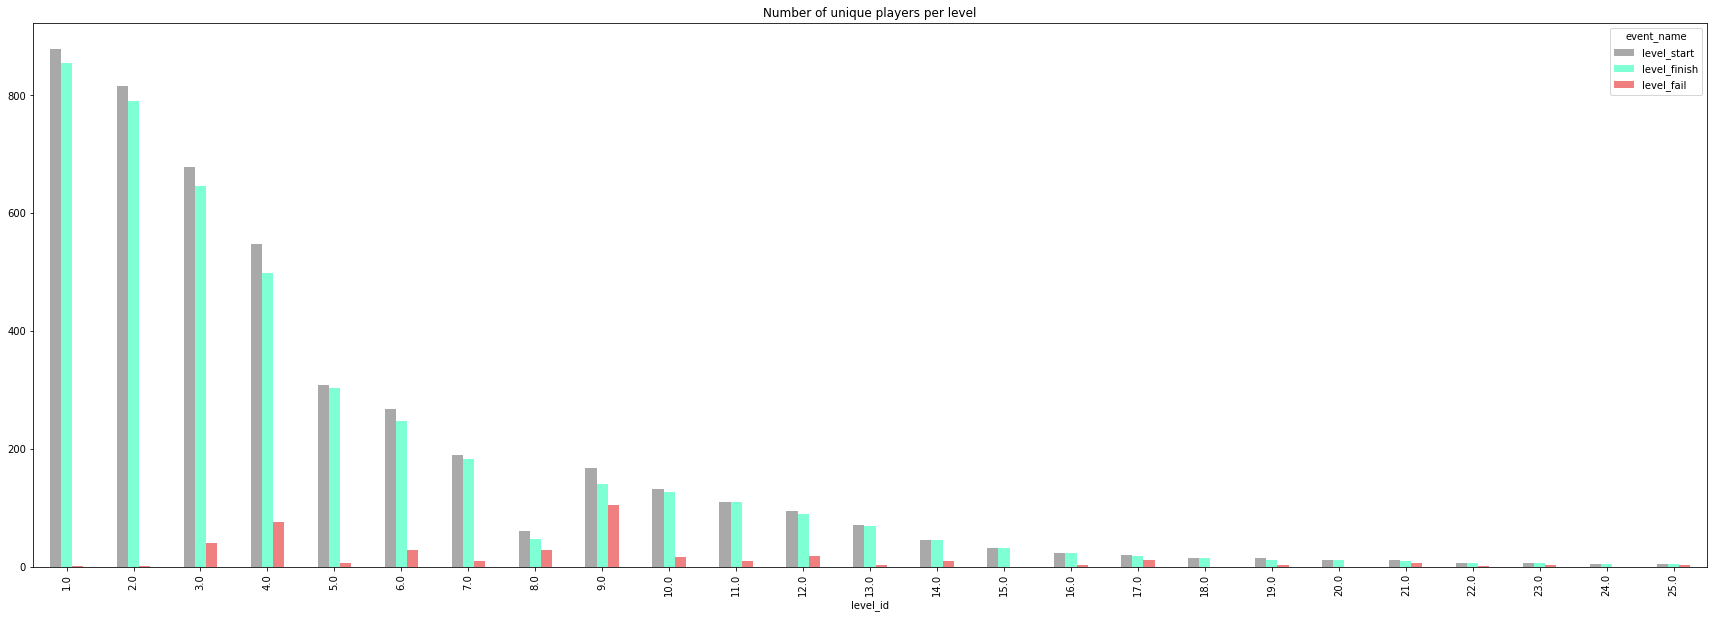

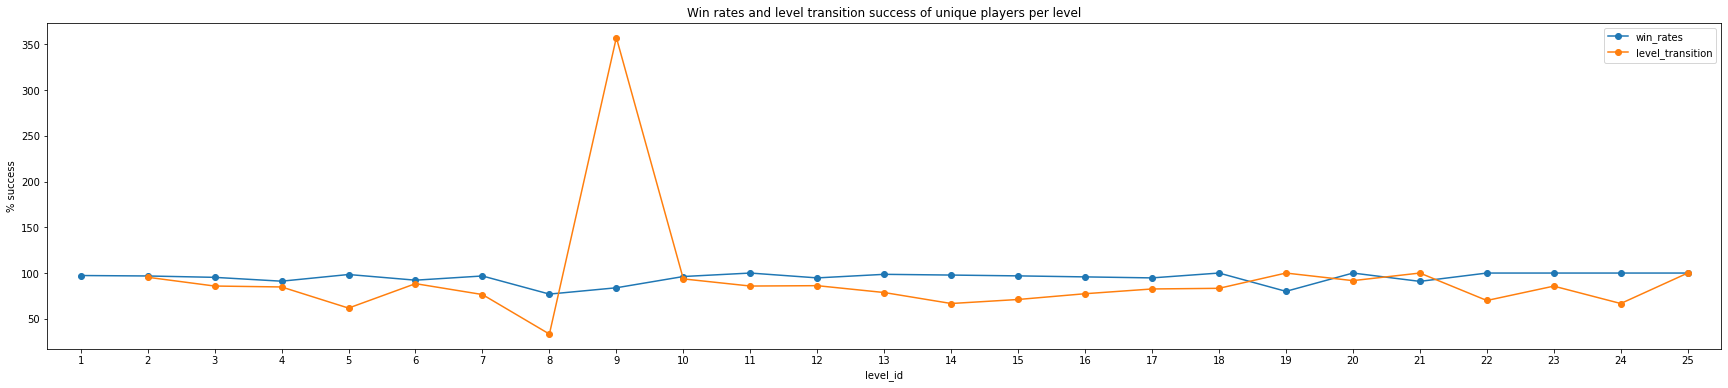

In [ ]:
_ = create_players_winrates_transition(events_levels)

###**Levels played by all games**

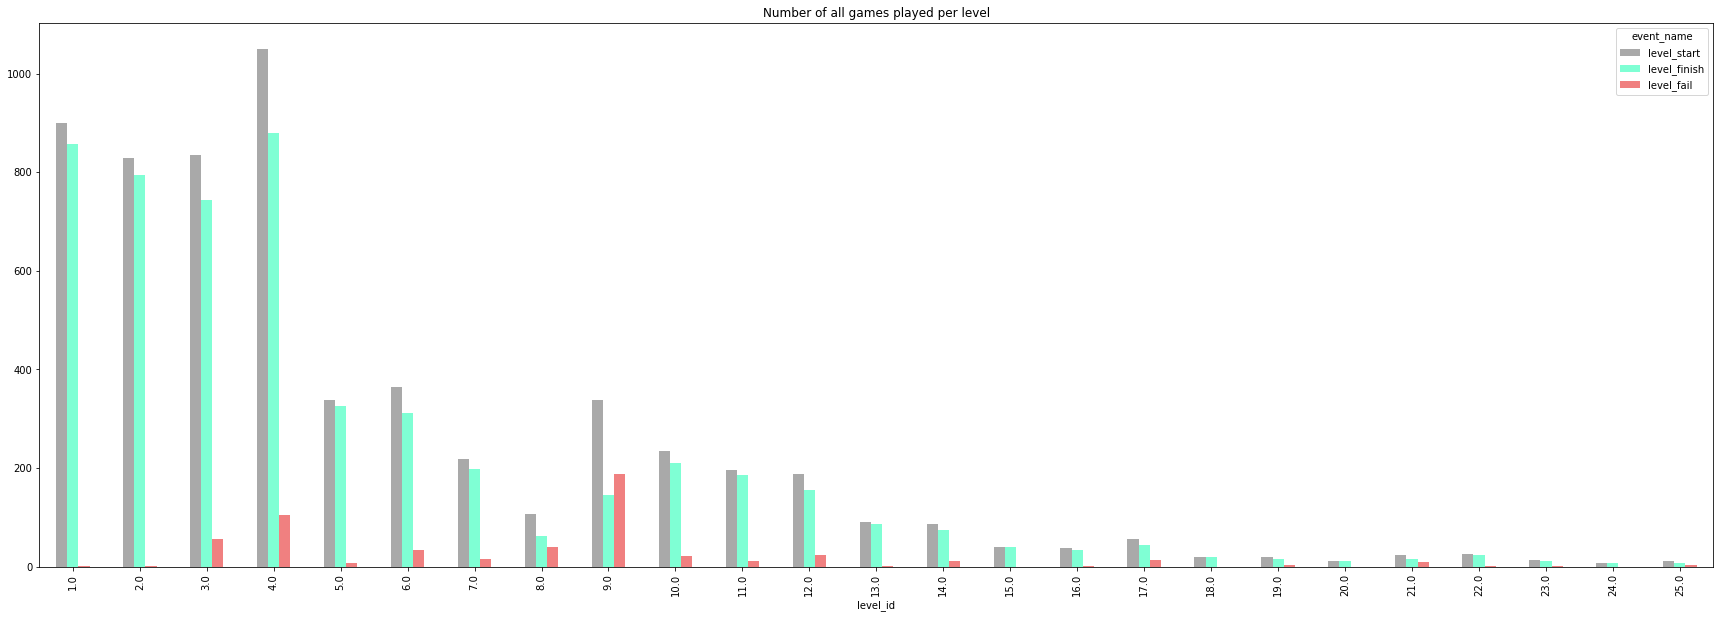

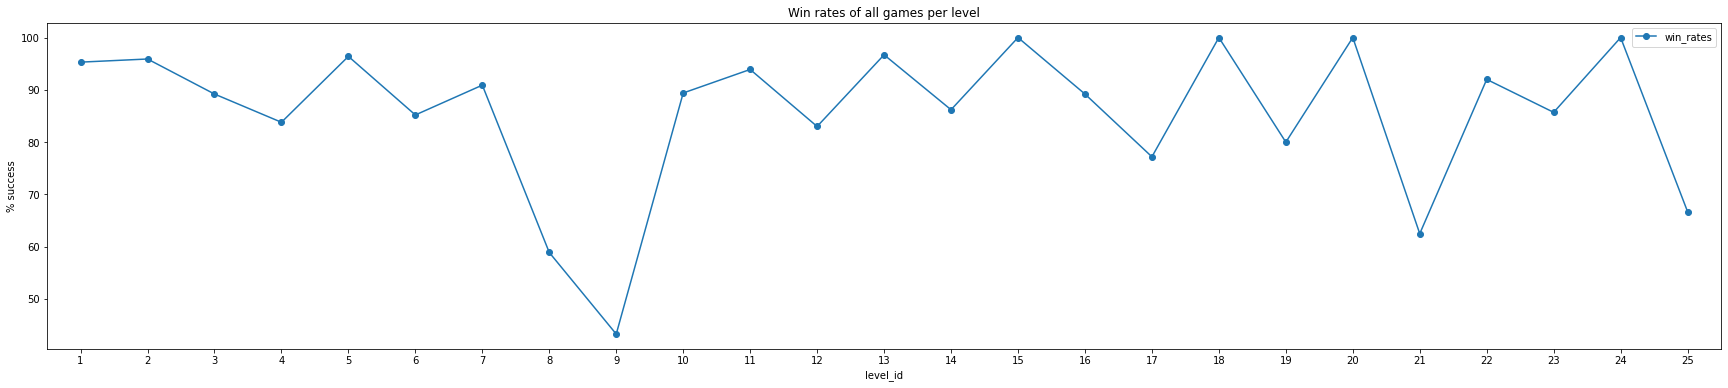

In [ ]:
_ = create_games_winrates_transition(events_levels)

###**Time analysis on levels**

In [ ]:
print('There are', events_levels.shape[0], 'events on levels.')
print('There are', len(events_levels.ga_session_id.unique()), 'unique sessions.')
print('There are', len(events_levels.user_pseudo_id.unique()), 'unique players.') 

There are 12056 events on levels.
There are 1136 unique sessions.
There are 880 unique players.


####**Average time spent on levels**



*   Calculates mean value of time spent on level per user
*   Calculates min value of time spent on level from all mean times of users



In [ ]:
avg_time_levels = do_time_analysis_levels(events_levels)
#time_level_min = t_d.groupby(['level_id']).avg_play_time.agg(['min'])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Calculate a number of players per level**

In [ ]:
levels_players = avg_time_levels.groupby(['level_id']).size()
levels_players = pd.DataFrame(levels_players, columns=['Players'])

Calculates percentile of time spent on level from all mean times of users.

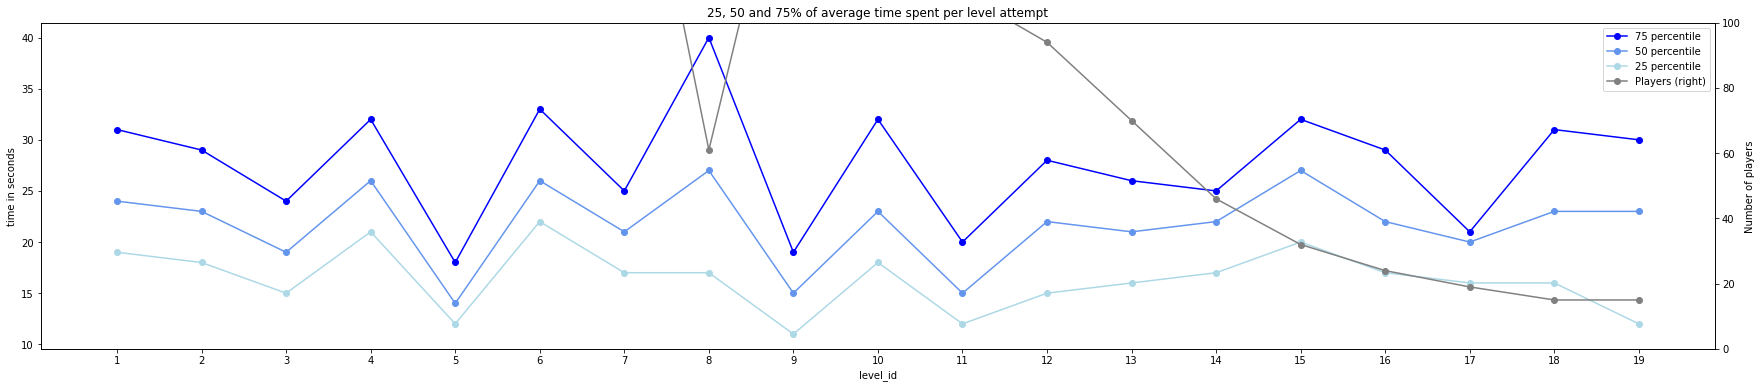

In [ ]:
time_level_25percentile = avg_time_levels.groupby(['level_id']).apply(calculate_25percentile)
time_level_50percentile = avg_time_levels.groupby(['level_id']).apply(calculate_50percentile)
time_level_75percentile = avg_time_levels.groupby(['level_id']).apply(calculate_75percentile)
time_level_percentiles = pd.concat([time_level_75percentile, time_level_50percentile, time_level_25percentile], axis=1)
plot_time_on_levels(time_level_percentiles[time_level_percentiles.index < 20], levels_players.Players[levels_players.index < 20], '25, 50 and 75% of average time spent per level attempt')

####**Total time spent on levels**

In [ ]:
total_time = do_sum_time_analysis_levels(events_levels)
total_time['sum_play_time'] = total_time['sum_play_time'].map(calc_sum_of_time)

Calculates 25 percentile of total time spent on level per user.

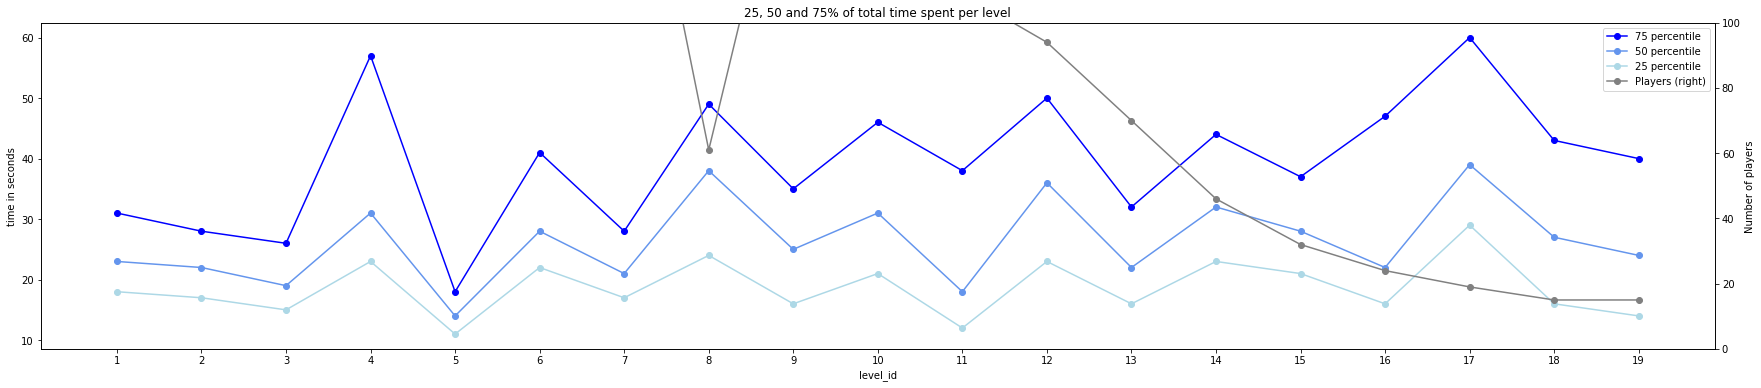

In [ ]:
sum_time_level_25percentile = total_time.groupby(['level_id']).apply(calculate_25percentile_sum)
sum_time_level_50percentile = total_time.groupby(['level_id']).apply(calculate_50percentile_sum)
sum_time_level_75percentile = total_time.groupby(['level_id']).apply(calculate_75percentile_sum)

sum_time_level_percentiles = pd.concat([sum_time_level_75percentile, sum_time_level_50percentile, sum_time_level_25percentile], axis=1)

plot_time_on_levels(sum_time_level_percentiles[sum_time_level_percentiles.index < 20], levels_players.Players[levels_players.index < 20], '25, 50 and 75% of total time spent per level')

##**Analysis on sessions**

###**Definitions**

In [ ]:
def rename_close_sessions(group):
  for i in range(len(group.event_timestamp)-1):
    if (group.ga_session_id.iloc[i] > "") and ((group.event_timestamp.iloc[i+1] - group.event_timestamp.iloc[i]) < datetime.timedelta(hours=1)):
      group.ga_session_id.iloc[i+1] = group.ga_session_id.iloc[i]
  return group

def give_length_session(group):
  result = {}
  result['session_length'] = group.event_timestamp.iloc[-1] - group.event_timestamp.iloc[0]
  return pd.Series(result, index=result.keys())

def number_sessions(data):
  data['session_Nr'] = 1
  for i in range(len(data.ga_session_id)-1):
    if data.user_pseudo_id.iloc[i+1] != data.user_pseudo_id.iloc[i]:
      data.session_Nr[i+1] = 1
    elif data.user_pseudo_id.iloc[i+1] == data.user_pseudo_id.iloc[i]:
      data.session_Nr[i+1] = data.session_Nr[i] + 1
  return data

def calculate_25percentile_ses(group):
  result = {}
  result['25 percentile'] = group.session_length.quantile(0.25)
  return pd.Series(result, index=result.keys())

def calculate_50percentile_ses(group):
  result = {}
  result['50 percentile'] = group.session_length.quantile(0.5)
  return pd.Series(result, index=result.keys())

def calculate_75percentile_ses(group):
  result = {}
  result['75 percentile'] = group.session_length.quantile(0.75)
  return pd.Series(result, index=result.keys())

def plot_time_on_sessions(data, column, title):
  lines = data[column]
  ax = data[['75 percentile', '50 percentile', '25 percentile']].astype('timedelta64[m]').plot(figsize=(30,15), color=('blue', 'cornflowerblue', 'lightblue'), legend=True, title=title, marker='o')
  plt.xticks(data.index)
  ax.set_ylabel('time in minutes')
  ax2 = lines.plot(x=data.index, secondary_y=True, color='grey', marker='o', legend=True)
  ax2.set_ylabel('Number of players')
  ax2.set_ylim([0,100])
  return plt.show()



###**Defining the session**

In [ ]:
data_uk
data_sessions = data_uk.drop(['event_date', 'platform', 'event_previous_timestamp', 'medium', 'country', 'app_version', 'traff_source'], axis=1)

**Definition of session:**

> If the app was removed in separate session, this can mislead the results
  -> events with removing the app are removed from df.

> All session_id which aren't a number are also removed from df.

> Events which are closer than 1h are considered as a same session
      -> session id is corrected



In [ ]:
app_removed = data_sessions[data_sessions.event_name == 'app_remove']
sessions = data_sessions[data_sessions.event_name != 'app_remove'].dropna(subset=['ga_session_id']).sort_values('event_timestamp')
sessions = sessions.groupby('user_pseudo_id').apply(rename_close_sessions)
sessions.tail()

,event_timestamp,event_name,user_pseudo_id,ga_session_id,level_id
819,2020-08-29 21:23:28.520007,level_start,F3E62351BC2B4EA39CCF6EE5C14559A4,1598736034,5.0
820,2020-08-29 21:23:40.146008,level_finish,F3E62351BC2B4EA39CCF6EE5C14559A4,1598736034,5.0
821,2020-08-29 21:23:51.876009,level_start,F3E62351BC2B4EA39CCF6EE5C14559A4,1598736034,6.0
822,2020-08-29 21:24:10.912010,level_finish,F3E62351BC2B4EA39CCF6EE5C14559A4,1598736034,6.0
823,2020-08-29 21:24:30.375011,user_engagement,F3E62351BC2B4EA39CCF6EE5C14559A4,1598736034,NaN


In [ ]:
print('There are', data_uk.shape[0], 'events.')
print('There are', sessions.shape[0], 'sessions.')
print('There are', len(sessions.user_pseudo_id.unique()), 'unique users.')
print('There are', app_removed.user_pseudo_id.count(), 'users who removed the app.')
print('There are', len(sessions.ga_session_id.unique()), 'sessions for unique users.')

There are 22655 events.
There are 20867 sessions.
There are 898 unique users.
There are 394 users who removed the app.
There are 1182 sessions for unique users.


###**Transition to next sessions**

In [ ]:
sessions_length = sessions.groupby(['user_pseudo_id', 'ga_session_id']).apply(give_length_session).reset_index().sort_values('user_pseudo_id')
sessions_length = number_sessions(sessions_length)
sessions_length.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,user_pseudo_id,ga_session_id,session_length,session_Nr
0,00dc03764ac37688a13a6aab8229bbf8,1598091249,00:02:47.675008,1
1,010BAE8B8C454226B789FB199B7D5141,1598471365,00:03:18.452006,1
2,0134175728B948C5A13F675B8FE225BB,1598042709,00:01:12.818003,1
3,0155C49239B843E0A286D46DEC35267A,1598358089,00:03:41.615010,1
4,01a68f02570e3303712e88f9fa92a0cc,1598243914,00:06:19.396013,1


Sessions_amount is a df of all sessions grouped with session_Nr, when function size() is called -> returns amount of players who have 1 session and 2 sessions, 3 sessions, it means that if player has for example 3 sessions, he is calculated in the amount for 1 session, 2 sessions and 3 sessions.

In [ ]:
sessions_amount = sessions_length.groupby('session_Nr').size().reset_index().rename(columns={0: 'amount_players'})
sessions_perc = calculate_percentage(sessions_amount, 'amount_players')
sessions_perc.head()

,session_Nr,amount_players,transition_perc
0,1,898,100.0
1,2,180,20.0
2,3,54,6.0
3,4,19,2.1
4,5,7,0.8


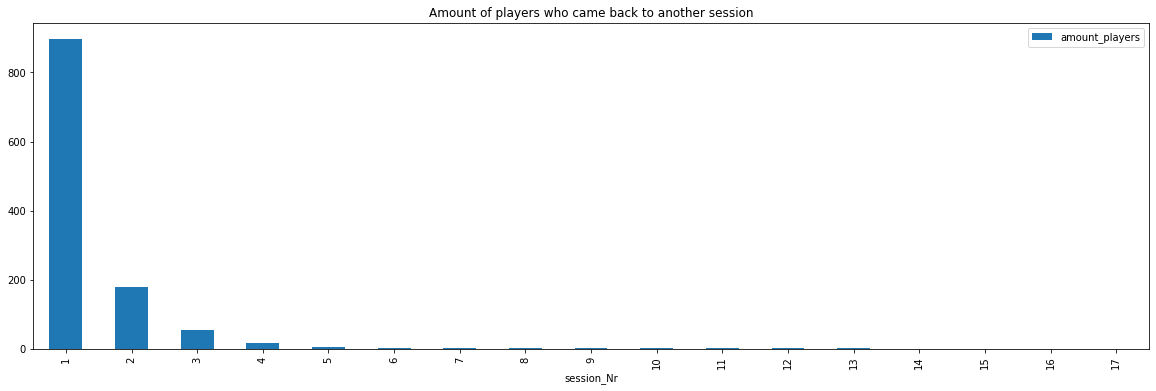

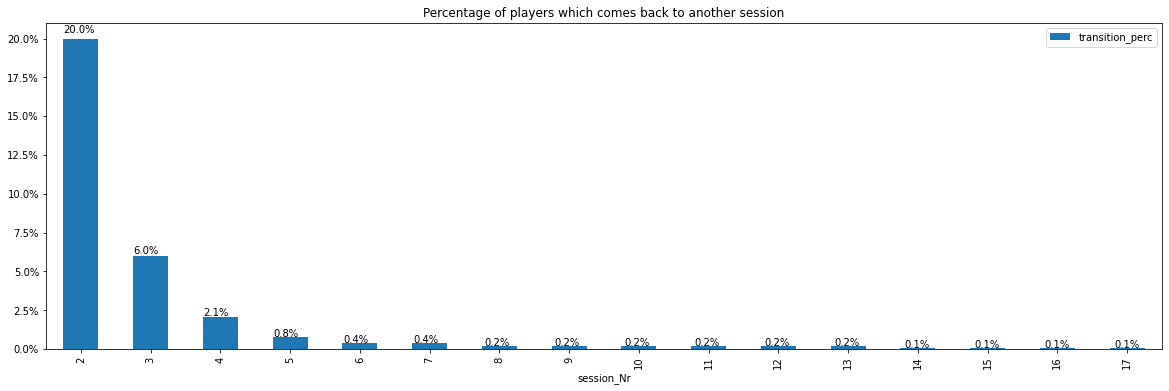

In [ ]:
sessions_perc.plot.bar(x='session_Nr', y='amount_players', title='Amount of players who came back to another session', figsize=(20, 6))
ax = sessions_perc.iloc[1:].plot.bar(x='session_Nr', y='transition_perc', title='Percentage of players which comes back to another session', figsize=(20, 6))
vals = ax.get_yticks()
ax.set_yticklabels(['{}%'.format(x) for x in vals])
for p in ax.patches:
  ax.annotate(str(p.get_height())+'%', (p.get_x()*1.005, p.get_height()*1.02))
plt.show()

###**Total time spent on session per player**

In [ ]:
sessions_length.head()

,user_pseudo_id,ga_session_id,session_length,session_Nr
0,00dc03764ac37688a13a6aab8229bbf8,1598091249,00:02:47.675008,1
1,010BAE8B8C454226B789FB199B7D5141,1598471365,00:03:18.452006,1
2,0134175728B948C5A13F675B8FE225BB,1598042709,00:01:12.818003,1
3,0155C49239B843E0A286D46DEC35267A,1598358089,00:03:41.615010,1
4,01a68f02570e3303712e88f9fa92a0cc,1598243914,00:06:19.396013,1


In [ ]:
sessions_time_25 = sessions_length.groupby('session_Nr').apply(calculate_25percentile_ses)
session_time_50 = sessions_length.groupby('session_Nr').apply(calculate_50percentile_ses)
sessions_time_75 = sessions_length.groupby('session_Nr').apply(calculate_75percentile_ses)
session_time_percentiles = pd.concat([sessions_time_75, session_time_50, sessions_time_25], axis=1)
session_time_percentiles['Players'] = sessions_perc['amount_players'].shift(1)
session_time_percentiles.head()

,75 percentile,50 percentile,25 percentile,Players
session_Nr,,,,
1,00:05:40.245508,00:02:46.433507,00:01:43.492755,898.0
2,00:04:43.819010,00:02:09.986505,00:00:50.047503,180.0
3,00:05:13.340010,00:02:31.718506,00:00:45.197000,54.0
4,00:04:44.500016,00:02:58.789010,00:01:13.142002,19.0
5,00:07:54.020516,00:03:00.321006,00:01:58.561004,7.0


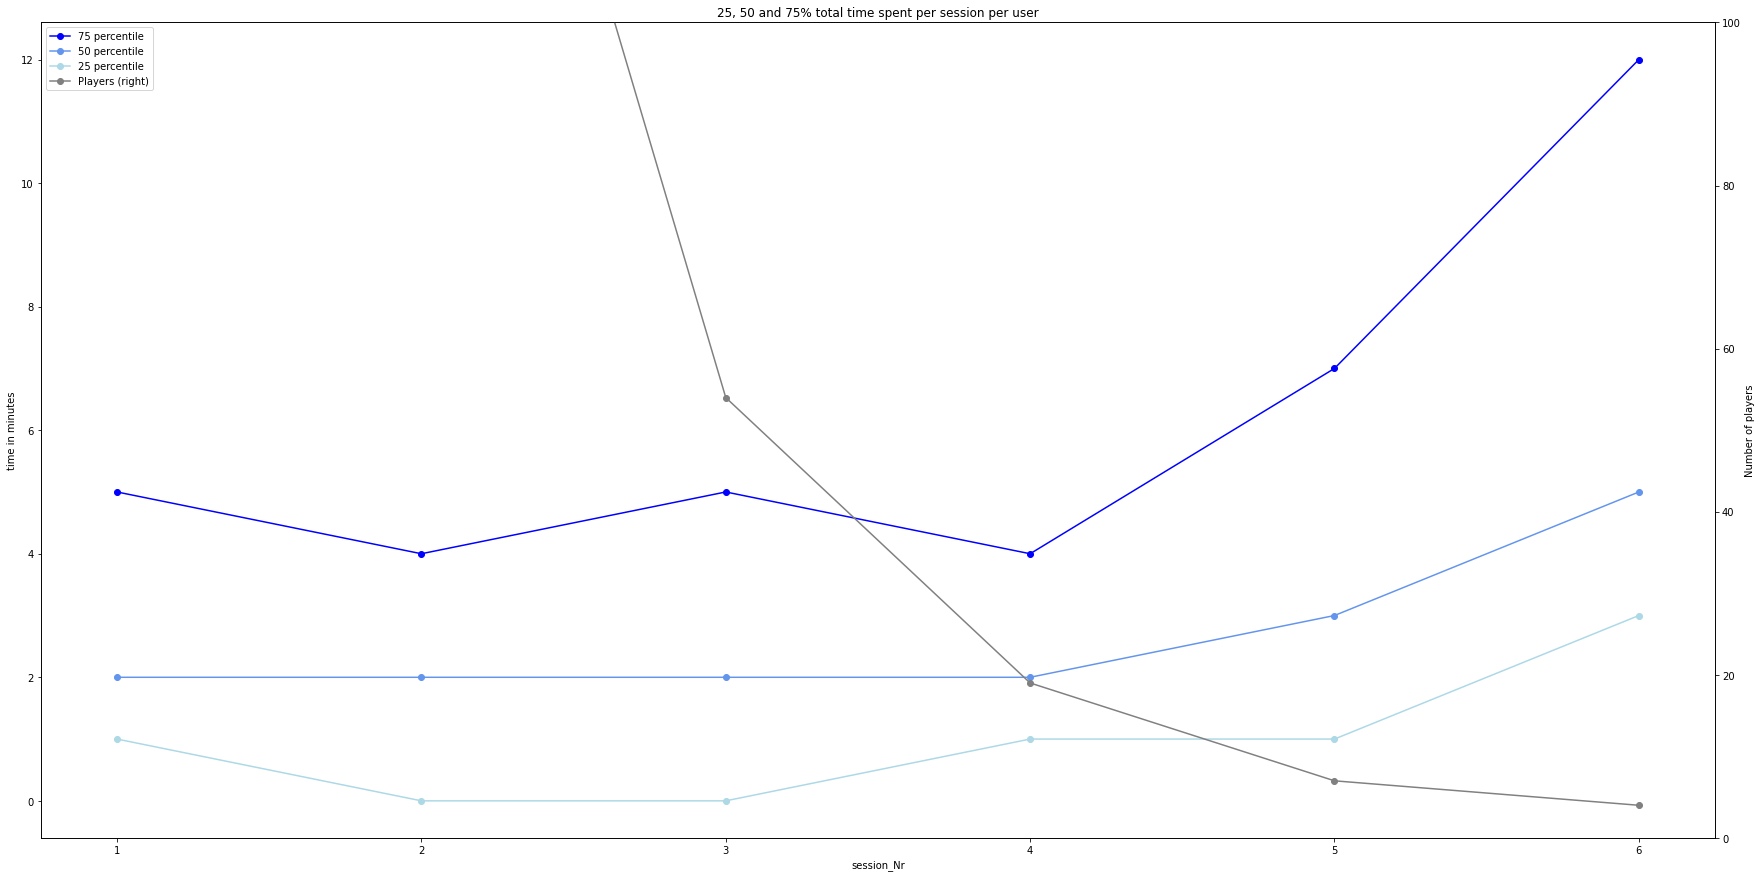

In [ ]:
plot_time_on_sessions(session_time_percentiles[session_time_percentiles.index < 7], 'Players', '25, 50 and 75% total time spent per session per user')

##**Analysis on days**

###**Definitions**

In [ ]:
def give_day_of_session(group):
  return pd.Series({}, index=[])

def count_days2(data):
  data['day_Nr'] = 1
  for i in range(data.shape[0]-1):
    if data.user_pseudo_id.iloc[i+1] == data.user_pseudo_id.iloc[i]:
      data.day_Nr.iloc[i+1] = data.day_Nr.iloc[i] + 1
  return data



###**Defining the days**

Dataframe without "app remove", sorted timestamps, session -> time gap < 1h

In [ ]:
sessions.head()

,event_timestamp,event_name,user_pseudo_id,ga_session_id,level_id
24319,2020-08-20 10:33:58.579000,session_start,51C9C38C36864087B79834B593369253,1597919638,NaN
24320,2020-08-20 10:33:58.579001,user_engagement,51C9C38C36864087B79834B593369253,1597919638,NaN
24321,2020-08-20 10:34:01.032002,screen_view,51C9C38C36864087B79834B593369253,1597919638,NaN
24322,2020-08-20 10:34:04.718000,sign_up,51C9C38C36864087B79834B593369253,1597919638,NaN
24323,2020-08-20 10:34:04.757001,login,51C9C38C36864087B79834B593369253,1597919638,NaN


New column "date" taken from event_timestamp

In [ ]:
events_dates = sessions
events_dates['date'] = events_dates.event_timestamp.dt.date
events_dates.head()

,event_timestamp,event_name,user_pseudo_id,ga_session_id,level_id,date
24319,2020-08-20 10:33:58.579000,session_start,51C9C38C36864087B79834B593369253,1597919638,NaN,2020-08-20
24320,2020-08-20 10:33:58.579001,user_engagement,51C9C38C36864087B79834B593369253,1597919638,NaN,2020-08-20
24321,2020-08-20 10:34:01.032002,screen_view,51C9C38C36864087B79834B593369253,1597919638,NaN,2020-08-20
24322,2020-08-20 10:34:04.718000,sign_up,51C9C38C36864087B79834B593369253,1597919638,NaN,2020-08-20
24323,2020-08-20 10:34:04.757001,login,51C9C38C36864087B79834B593369253,1597919638,NaN,2020-08-20


###**Transition to next days**

*   DF grouped with user_id and date, sorted by user_id
*   If a player has more dates -> calculated as number of days
*   The amount of players having 1 and more days
*   Calculated the percentage



In [ ]:
day_of_session = events_dates.groupby(['user_pseudo_id', 'date']).apply(give_day_of_session).reset_index().sort_values(['user_pseudo_id'])
days_of_session = count_days2(day_of_session)
days_of_session = days_of_session.groupby('day_Nr').size().reset_index().rename(columns={0: 'amount_players'})                      
days_of_session = calculate_percentage(days_of_session, 'amount_players')
days_of_session

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,day_Nr,amount_players,transition_perc
0,1,898,100.0
1,2,119,13.3
2,3,25,2.8
3,4,6,0.7
4,5,3,0.3


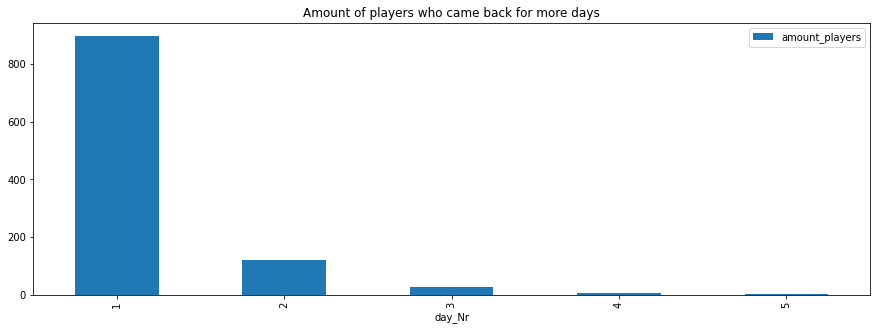

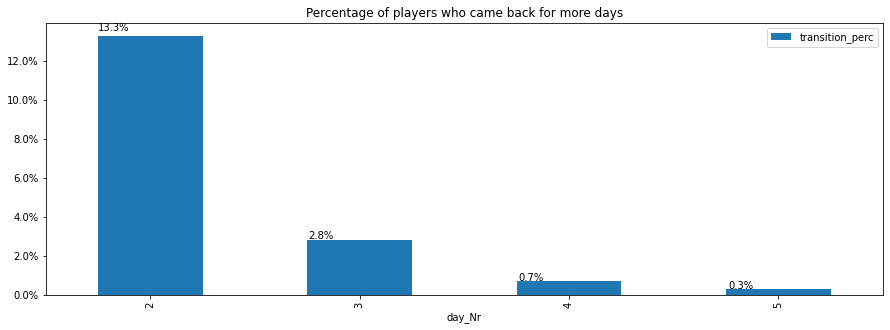

In [ ]:
days_of_session.plot.bar(x='day_Nr', y='amount_players', title='Amount of players who came back for more days', figsize=(15,5))
ax = days_of_session.iloc[1:].plot.bar(x='day_Nr', y='transition_perc', title='Percentage of players who came back for more days', figsize=(15, 5))
vals = ax.get_yticks()
ax.set_yticklabels(['{}%'.format(x) for x in vals])
for p in ax.patches:
  ax.annotate(str(p.get_height())+'%', (p.get_x()*1.005, p.get_height()*1.02))
plt.show()